In [11]:
from sklearn import svm
import GPyOpt, numpy as np

In [2]:
%run load_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevalues: (172, 104)
rnaseq_mod_nodevalues: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
from paramz import Model, Param

In [152]:
class ParamzSVC(Model):
    def __init__(self, X, y, C=1., gamma=1., name='ParamzSVC'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzSVC, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.C = Param('C', C)
        self.gamma = Param('gamma', gamma)
        self.link_parameter(self.C)
        #self.link_parameter(self.gamma)
        self.sk = StratifiedKFold(train_labels, shuffle=True)
        
    def parameters_changed(self):
        from sklearn.metrics import accuracy_score
    
        self._acc = 0.
    
        for train_index, test_index in self.sk:
            #svc = svm.SVC(C=float(self.C.values), gamma=float(self.gamma.values), decision_function_shape='ovr', probability=False, class_weight='balanced')
            svc = svm.LinearSVC(C=float(self.C.values), class_weight='balanced')
            svc = svc.fit(self.X[train_index], self.y[train_index])
            prediction = svc.predict(self.X[test_index])
            self._acc += accuracy_score(self.y[test_index], prediction)/float(self.sk.n_folds)
            
    def objective_function(self):
        import numpy as np
        print self._acc
        return -np.atleast_1d(self._acc)

In [153]:
train_idx = rnaseq_design.Set == rnaseq_design.Set.unique()[0]
test_idx = ~train_idx

In [154]:
train_set = rnaseq_effector_genes.loc[:, train_idx]
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
train_set[:] = normalizer.fit_transform(train_set.T).T

test_set = rnaseq_effector_genes.loc[:, test_idx]
test_set[:] = normalizer.transform(test_set.T).T

In [155]:
train_labels = rnaseq_design.loc[train_idx, 'Effect']
test_labels = rnaseq_design.loc[test_idx, 'Effect']

In [156]:
m = ParamzSVC(train_set.T.values, train_labels.values)

In [157]:
def f(X):
    ret = np.empty((X.shape[0],1))
    for i in range(X.shape[0]):
        ret[i] = m._objective(X[i])
    return ret

m_opt = GPyOpt.methods.BayesianOptimization(f, 
                                            bounds=[
        (1e-10,.1),
        #(0,.01)
    ], 
                                            acquisition='LCB',
                                            acquisition_par = 2,
                                            type_initial_design='latin')

0.886507936508
0.903174603175
0.903174603175


In [158]:
m_opt.run_optimization(60,                                   # evaluation budget
                                    eps=1e-5)

0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175
0.903174603175


KeyboardInterrupt: 

In [ ]:
%matplotlib inline

In [ ]:
r = []
for c in np.linspace(1e-10,1e-1, 100):
    m.C = c
    r.append(m.objective_function())

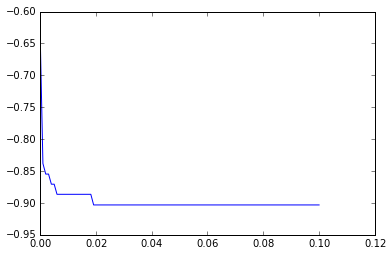

In [167]:
plt.plot(np.linspace(1e-10,1e-1, 100), r)

In [165]:
from matplotlib import pyplot as plt

In [ ]:
m_opt.plot_acquisition()

In [86]:
m_opt.x_opt

array([ 1.,  0.])

In [70]:
svc.fit(train_set.T.values, train_labels.values)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [71]:
prediction = svc.predict(test_set.T)

In [79]:
from sklearn.metrics import accuracy_score, classification_report

In [77]:
from matplotlib import pyplot as plt
%matplotlib inline

In [82]:
classification_report?

In [80]:
print classification_report(test_labels, prediction)

             precision    recall  f1-score   support

    Control       1.00      0.50      0.67         6
   Effect_1       0.86      0.67      0.75         9
   Effect_2       0.29      0.44      0.35         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
   Effect_6       0.00      0.00      0.00         9
   Effect_7       0.00      0.00      0.00         9

avg / total       0.39      0.31      0.33        42



/Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [85]:
pd.value_counts(prediction)

Effect_2    14
Effect_4    12
Effect_1     7
Effect_3     6
Control      3
dtype: int64

In [83]:
print accuracy_score(test_labels, prediction)

0.309523809524
